In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from sklearn.utils import resample

In [2]:
# Assign PID labels for each instance
# With each of 4 kinds of PID labels, extract the corresponding instance from the train, val and test dataset to form the new dataset
# There will be 4 (pid labels) * 3 (train, val, test) = 12 new datasets
# This will be repeated for each task, so create with the task name under the task folder

In [3]:
def split_ids(id_string, n=8):
    # Convert to string if the input is not already a string
    id_string = str(id_string)
    # Assuming the hadm_id and stay_id are concatenated as one string
    # Convert hadm_id to float to match the format in the original dataset
    hadm_id = float(id_string[:8])  # Convert first part to float
    stay_id = int(id_string[8:])   # Convert remaining part to int
    return hadm_id, stay_id

In [4]:
def reform_pkl_ids(file_path, all_pred):
    with open(file_path, 'rb') as f:
        train_stays_list = pickle.load(f)
    matched_list = []
    for id_string in all_pred['ids']:
        hadm_id, stay_id = split_ids(id_string)
        for record in train_stays_list:
            if float(record.get('hadm_id')) == hadm_id and int(record.get('stay_id')) == stay_id:
                matched_list.append(record)
    print("Matched list length: ", len(matched_list))
    return matched_list

In [5]:
def oversample_pkl_ids(file_path, all_pred, pid_label, min_samples=500):
    with open(file_path, 'rb') as f:
        train_stays_list = pickle.load(f)
    
    matched_list = []
    for id_string in all_pred['ids']:
        hadm_id, stay_id = split_ids(id_string)
        for record in train_stays_list:
            if float(record.get('hadm_id')) == hadm_id and int(record.get('stay_id')) == stay_id:
                matched_list.append(record)

    print(f"Matched list length before sampling for PID {pid_label}: {len(matched_list)}")

    # Perform oversampling if the PID label is not 'R' and the sample size is below the minimum threshold
    if pid_label != 'R' and len(matched_list) < min_samples:
        matched_list = resample(matched_list, replace=True, n_samples=min_samples, random_state=123)
        print(f"Performed oversampling for PID {pid_label}, new length: {len(matched_list)}")

    return matched_list

# Two modalities

In [6]:
# Define a function to assign PID based on the rules
def assign_pid_two(row, A=str, B=str):
    if row[A] == 0 and row[B] == 0 and row['Multi'] == 0:
        return 'R'
    elif row[A] == 0 and row[B] == 1 and row['Multi'] == 1:
        return 'U'
    elif row[A] == 1 and row[B] == 0 and row['Multi'] == 1:
        return 'U'
    elif row[A] == 0 and row[B] == 0 and row['Multi'] == 1:
        return 'S'
    elif row[A] == 1 and row[B] == 0 and row['Multi'] == 0:
        return 'U'
    elif row[A] == 0 and row[B] == 1 and row['Multi'] == 0:
        return 'U'
    elif row[A] == 1 and row[B] == 1 and row['Multi'] == 0:
        return 'S'
    elif row[A] == 1 and row[B] == 1 and row['Multi'] == 1:
        return 'R'
    return None

In [7]:
def assign_pid_2dataset(df_A, df_B, multi_pred, A=str, B=str):
    # Rename and merge operations as before
    df_A = df_A[['ids', 'Ground_Truth', 'Predicted']].rename(columns={'Predicted': A})
    df_B = df_B[['ids', 'Predicted']].rename(columns={'Predicted': B})
    multi_pred = multi_pred[['ids', 'Predicted']].rename(columns={'Predicted': 'Multi'})

    all_pred = pd.merge(pd.merge(df_A, df_B, on='ids'), multi_pred, on='ids')
    print(all_pred.head())
    all_pred['PID'] = all_pred.apply(lambda row: assign_pid_two(row, A, B), axis=1)
    print("Counts Table:")
    print(all_pred['PID'].value_counts().reset_index(name='Count').rename(columns={'index': 'PID'}))
    return all_pred

In [19]:
tasks = ['ihm', 'los']
datasets = ['train', 'val', 'test']
PID_labels = ['R', 'U', 'S']

In [20]:
# TS_CXR
for task in tasks:
    for dataset in datasets:
        print(f"Starting {task} {dataset} dataset")
        df_A = pd.read_csv(f'/data/wang/junh/results/Fuse_moe/all_{task}/labels/TS_{dataset}_results.csv')
        df_B = pd.read_csv(f'/data/wang/junh/results/Fuse_moe/all_{task}/labels/CXR_{dataset}_results.csv')
        multi_pred = pd.read_csv(f'/data/wang/junh/results/Fuse_moe/all_{task}/labels/TS_CXR_{dataset}_results.csv')

        all_pred = assign_pid_2dataset(df_A, df_B, multi_pred, 'TS', 'CXR')
        file_path = f'/data/wang/junh/datasets/multimodal/preprocessing/{dataset}_{task}-48-cxr-notes-ecg_stays.pkl'

        for PID_label in PID_labels:
            all_pred_PID = all_pred[all_pred['PID'] == PID_label]

            new_pkl = reform_pkl_ids(file_path, all_pred_PID)
            
            # if task == 'train':
            #     new_pkl = reform_pkl_ids(file_path, all_pred_PID, PID_label, min_samples=500 if PID_label != 'R' else None)
            # else:
            #     new_pkl = reform_pkl_ids(file_path, all_pred_PID)
            
            f_path = f'/data/wang/junh/datasets/multimodal/pid_2mod/TS_CXR/{dataset}_{task}_{PID_label}_stays.pkl'
            with open(f_path, 'wb') as f:
                pickle.dump(new_pkl, f)
            print(f"Finished {task} {dataset} {PID_label} dataset")

Starting ihm train dataset
                ids  Ground_Truth  TS  CXR  Multi
0  2744935933836951             1   0    0      0
1  2525011538434928             0   0    0      0
2  2336299538503601             0   0    0      0
3  2083309330893916             0   0    0      0
4  2068010236562457             0   0    0      0
Counts Table:
  PID  Count
0   R   2968
1   U    473
2   S    183
Matched list length:  2968
Finished ihm train R dataset
Matched list length:  473
Finished ihm train U dataset
Matched list length:  183
Finished ihm train S dataset
Starting ihm val dataset
                ids  Ground_Truth  TS  CXR  Multi
0  2094909739420605             0   0    0      0
1  2799304839673498             0   0    0      0
2  2629078037270178             0   0    0      0
3  2813162434726635             0   1    0      1
4  2267088036556828             0   0    0      0
Counts Table:
  PID  Count
0   R    668
1   U     71
2   S     37
Matched list length:  668
Finished ihm val R datas

In [17]:
# TS_Text
for task in tasks:
    for dataset in datasets:
        print(f"Starting {task} {dataset} dataset")
        df_A = pd.read_csv(f'/data/wang/junh/results/Fuse_moe/all_{task}/labels/TS_{dataset}_results.csv')
        df_B = pd.read_csv(f'/data/wang/junh/results/Fuse_moe/all_{task}/labels/Text_{dataset}_results.csv')
        multi_pred = pd.read_csv(f'/data/wang/junh/results/Fuse_moe/all_{task}/labels/TS_CXR_{dataset}_results.csv')

        all_pred = assign_pid_2dataset(df_A, df_B, multi_pred, 'TS', 'Text')
        file_path = f'/data/wang/junh/datasets/multimodal/preprocessing/{dataset}_{task}-48-cxr-notes-ecg_stays.pkl'

        for PID_label in PID_labels:
            all_pred_PID = all_pred[all_pred['PID'] == PID_label]

            new_pkl = reform_pkl_ids(file_path, all_pred_PID)
            
            # if task == 'train':
            #     new_pkl = reform_pkl_ids(file_path, all_pred_PID, PID_label, min_samples=500 if PID_label != 'R' else None)
            # else:
            #     new_pkl = reform_pkl_ids(file_path, all_pred_PID)
            
            f_path = f'/data/wang/junh/datasets/multimodal/pid_2mod/TS_Text/{dataset}_{task}_{PID_label}_stays.pkl'
            with open(f_path, 'wb') as f:
                pickle.dump(new_pkl, f)
            print(f"Finished {task} {dataset} {PID_label} dataset")

Starting ihm train dataset
                ids  Ground_Truth  TS  Text  Multi
0  2744935933836951             1   0     0      0
1  2525011538434928             0   0     0      0
2  2336299538503601             0   0     0      0
3  2083309330893916             0   0     0      0
4  2068010236562457             0   0     0      0
Counts Table:
  PID  Count
0   R   2972
1   U    469
2   S    183
Matched list length:  2972
Finished ihm train R dataset
Matched list length:  0
Finished ihm train Umaj dataset
Matched list length:  0
Finished ihm train Umin dataset
Matched list length:  183
Finished ihm train S dataset
Starting ihm val dataset
                ids  Ground_Truth  TS  Text  Multi
0  2094909739420605             0   0     0      0
1  2799304839673498             0   0     0      0
2  2629078037270178             0   0     0      0
3  2813162434726635             0   1     0      1
4  2267088036556828             0   0     0      0
Counts Table:
  PID  Count
0   R    669
1   U  

# Three modalities

In [6]:
# Define a function to assign PID based on the rules
def assign_pid(row):
    if row['TS'] == 0 and row['Text'] == 0 and row['CXR'] == 0 and row['Multi'] == 0:
        return 'R'
    elif row['TS'] == 0 and row['Text'] == 0 and row['CXR'] == 1 and row['Multi'] == 0:
        return 'Umaj'
    elif row['TS'] == 0 and row['Text'] == 1 and row['CXR'] == 0 and row['Multi'] == 0:
        return 'Umaj'
    elif row['TS'] == 0 and row['Text'] == 1 and row['CXR'] == 1 and row['Multi'] == 0:
        return 'Umin'
    elif row['TS'] == 1 and row['Text'] == 0 and row['CXR'] == 0 and row['Multi'] == 0:
        return 'Umaj'
    elif row['TS'] == 1 and row['Text'] == 0 and row['CXR'] == 1 and row['Multi'] == 0:
        return 'Umin'
    elif row['TS'] == 1 and row['Text'] == 1 and row['CXR'] == 0 and row['Multi'] == 0:
        return 'Umin'
    elif row['TS'] == 1 and row['Text'] == 1 and row['CXR'] == 1 and row['Multi'] == 0:
        return 'S'
    elif row['TS'] == 0 and row['Text'] == 0 and row['CXR'] == 0 and row['Multi'] == 1:
        return 'S'
    elif row['TS'] == 0 and row['Text'] == 0 and row['CXR'] == 1 and row['Multi'] == 1:
        return 'Umin'
    elif row['TS'] == 0 and row['Text'] == 1 and row['CXR'] == 0 and row['Multi'] == 1:
        return 'Umaj'
    elif row['TS'] == 0 and row['Text'] == 1 and row['CXR'] == 1 and row['Multi'] == 1:
        return 'Umaj'
    elif row['TS'] == 1 and row['Text'] == 0 and row['CXR'] == 0 and row['Multi'] == 1:
        return 'Umin'
    elif row['TS'] == 1 and row['Text'] == 0 and row['CXR'] == 1 and row['Multi'] == 1:
        return 'Umaj'
    elif row['TS'] == 1 and row['Text'] == 1 and row['CXR'] == 0 and row['Multi'] == 1:
        return 'Umin'
    elif row['TS'] == 1 and row['Text'] == 1 and row['CXR'] == 1 and row['Multi'] == 1:
        return 'R'
    return None

In [7]:
def assign_pid_3dataset(ts_pred, text_pred, cxr_pred, multi_pred):
    # Rename and merge operations as before
    ts_pred = ts_pred[['ids', 'Ground_Truth', 'Predicted']].rename(columns={'Predicted': 'TS'})
    text_pred = text_pred[['ids', 'Predicted']].rename(columns={'Predicted': 'Text'})
    cxr_pred = cxr_pred[['ids', 'Predicted']].rename(columns={'Predicted': 'CXR'})
    multi_pred = multi_pred[['ids', 'Predicted']].rename(columns={'Predicted': 'Multi'})

    all_pred = pd.merge(pd.merge(pd.merge(ts_pred, text_pred, on='ids'), cxr_pred, on='ids'), multi_pred, on='ids')
    all_pred['PID'] = all_pred.apply(assign_pid, axis=1)  # Ensure assign_pid function is defined elsewhere
    print("Counts Table:")
    print(all_pred['PID'].value_counts().reset_index(name='Count').rename(columns={'index': 'PID'}))
    return all_pred

In [8]:
tasks = ['ihm', 'los']
datasets = ['train', 'val', 'test']
PID_labels = ['R', 'Umaj', 'Umin', 'S']

In [9]:
for task in tasks:
    for dataset in datasets:
        print(f"Starting {task} {dataset} dataset")
        ts_pred = pd.read_csv(f'/data/wang/junh/results/Fuse_moe/all_{task}/labels/TS_{dataset}_results.csv')
        text_pred = pd.read_csv(f'/data/wang/junh/results/Fuse_moe/all_{task}/labels/Text_{dataset}_results.csv')
        cxr_pred = pd.read_csv(f'/data/wang/junh/results/Fuse_moe/all_{task}/labels/CXR_{dataset}_results.csv')
        multi_pred = pd.read_csv(f'/data/wang/junh/results/Fuse_moe/all_{task}/labels/TS_CXR_Text_{dataset}_results.csv')

        all_pred = assign_pid_3dataset(ts_pred, text_pred, cxr_pred, multi_pred)
        file_path = f'/data/wang/junh/datasets/multimodal/augmentation/{dataset}_{task}-48-cxr-notes-ecg_stays.pkl'

        for PID_label in PID_labels:
            all_pred_PID = all_pred[all_pred['PID'] == PID_label]
            
            if task == 'train':
                new_pkl = oversample_pkl_ids(file_path, all_pred_PID, PID_label, min_samples=500 if PID_label != 'R' else None)
            else:
                new_pkl = reform_pkl_ids(file_path, all_pred_PID)
            
            f_path = f'/data/wang/junh/datasets/multimodal/augmentation/pid_3mod/{dataset}_{task}_{PID_label}_stays.pkl'
            with open(f_path, 'wb') as f:
                pickle.dump(new_pkl, f)
            print(f"Finished {task} {dataset} {PID_label} dataset")

Starting ihm train dataset
Counts Table:
    PID  Count
0     R   2964
1  Umin    257
2  Umaj    225
3     S    178
Matched list length:  2964
Finished ihm train R dataset
Matched list length:  225
Finished ihm train Umaj dataset
Matched list length:  257
Finished ihm train Umin dataset
Matched list length:  178
Finished ihm train S dataset
Starting ihm val dataset
Counts Table:
    PID  Count
0     R    645
1     S     60
2  Umin     56
3  Umaj     15
Matched list length:  645
Finished ihm val R dataset
Matched list length:  15
Finished ihm val Umaj dataset
Matched list length:  56
Finished ihm val Umin dataset
Matched list length:  60
Finished ihm val S dataset
Starting ihm test dataset
Counts Table:
    PID  Count
0     R    647
1     S     62
2  Umin     44
3  Umaj     23
Matched list length:  647
Finished ihm test R dataset
Matched list length:  23
Finished ihm test Umaj dataset
Matched list length:  44
Finished ihm test Umin dataset
Matched list length:  62
Finished ihm test S da

# Combined

In [21]:
# Define a function to assign PID based on the rules
def assign_pid_combine_3(row):
    if row['TS'] == 0 and row['Text'] == 0 and row['CXR'] == 0 and row['Multi'] == 0:
        return 'R'
    elif row['TS'] == 1 and row['Text'] == 1 and row['CXR'] == 1 and row['Multi'] == 1:
        return 'R'
    else:
        return 'O'
    return None

In [22]:
def assign_pid_combine_2(row, A=str, B=str):
    if row[A] == 0 and row[B] == 0 and row['Multi'] == 0:
        return 'R'
    elif row[A] == 1 and row[B] == 1 and row['Multi'] == 1:
        return 'R'
    else:
        return 'O'
    return None

In [19]:
def assign_pid_3dataset_combined(ts_pred, text_pred, cxr_pred, multi_pred):
    # Rename and merge operations as before
    ts_pred = ts_pred[['ids', 'Ground_Truth', 'Predicted']].rename(columns={'Predicted': 'TS'})
    text_pred = text_pred[['ids', 'Predicted']].rename(columns={'Predicted': 'Text'})
    cxr_pred = cxr_pred[['ids', 'Predicted']].rename(columns={'Predicted': 'CXR'})
    multi_pred = multi_pred[['ids', 'Predicted']].rename(columns={'Predicted': 'Multi'})

    all_pred = pd.merge(pd.merge(pd.merge(ts_pred, text_pred, on='ids'), cxr_pred, on='ids'), multi_pred, on='ids')
    all_pred['PID'] = all_pred.apply(assign_pid_combine_3, axis=1)  # Ensure assign_pid function is defined elsewhere
    print("Counts Table:")
    print(all_pred['PID'].value_counts().reset_index(name='Count').rename(columns={'index': 'PID'}))
    return all_pred

In [14]:
tasks = ['ihm', 'los']
datasets = ['train', 'val', 'test']
PID_labels = ['R', 'O']

In [24]:
for task in tasks:
    for dataset in datasets:
        print(f"Starting {task} {dataset} dataset")
        ts_pred = pd.read_csv(f'/data/wang/junh/results/Fuse_moe/all_{task}/labels/TS_{dataset}_results.csv')
        text_pred = pd.read_csv(f'/data/wang/junh/results/Fuse_moe/all_{task}/labels/Text_{dataset}_results.csv')
        cxr_pred = pd.read_csv(f'/data/wang/junh/results/Fuse_moe/all_{task}/labels/CXR_{dataset}_results.csv')
        multi_pred = pd.read_csv(f'/data/wang/junh/results/Fuse_moe/all_{task}/labels/TS_CXR_Text_{dataset}_results.csv')

        all_pred = assign_pid_3dataset_combined(ts_pred, text_pred, cxr_pred, multi_pred)
        file_path = f'/data/wang/junh/datasets/multimodal/preprocessing/{dataset}_{task}-48-cxr-notes-ecg_stays.pkl'

        for PID_label in PID_labels:
            all_pred_PID = all_pred[all_pred['PID'] == PID_label]
            
            if task == 'train':
                new_pkl = oversample_pkl_ids(file_path, all_pred_PID, PID_label, min_samples=500 if PID_label != 'R' else None)
            else:
                new_pkl = reform_pkl_ids(file_path, all_pred_PID)
            
            f_path = f'/data/wang/junh/datasets/multimodal/pid_combined/3mod/{dataset}_{task}_{PID_label}_stays.pkl'
            with open(f_path, 'wb') as f:
                pickle.dump(new_pkl, f)
            print(f"Finished {task} {dataset} {PID_label} dataset")

Starting ihm train dataset
Counts Table:
  PID  Count
0   R   2964
1   O    660
Matched list length:  2964
Finished ihm train R dataset
Matched list length:  660
Finished ihm train O dataset
Starting ihm val dataset
Counts Table:
  PID  Count
0   R    645
1   O    131
Matched list length:  645
Finished ihm val R dataset
Matched list length:  131
Finished ihm val O dataset
Starting ihm test dataset
Counts Table:
  PID  Count
0   R    647
1   O    129
Matched list length:  647
Finished ihm test R dataset
Matched list length:  129
Finished ihm test O dataset
Starting los train dataset
Counts Table:
  PID  Count
0   O   2355
1   R   1269
Matched list length:  1269
Finished los train R dataset
Matched list length:  2355
Finished los train O dataset
Starting los val dataset
Counts Table:
  PID  Count
0   O    503
1   R    273
Matched list length:  273
Finished los val R dataset
Matched list length:  503
Finished los val O dataset
Starting los test dataset
Counts Table:
  PID  Count
0   O    

In [25]:
def assign_pid_2dataset_combined(df_A, df_B, multi_pred, A=str, B=str):
    # Rename and merge operations as before
    df_A = df_A[['ids', 'Ground_Truth', 'Predicted']].rename(columns={'Predicted': A})
    df_B = df_B[['ids', 'Predicted']].rename(columns={'Predicted': B})
    multi_pred = multi_pred[['ids', 'Predicted']].rename(columns={'Predicted': 'Multi'})

    all_pred = pd.merge(pd.merge(df_A, df_B, on='ids'), multi_pred, on='ids')
    print(all_pred.head())
    all_pred['PID'] = all_pred.apply(lambda row: assign_pid_combine_2(row, A, B), axis=1)
    print("Counts Table:")
    print(all_pred['PID'].value_counts().reset_index(name='Count').rename(columns={'index': 'PID'}))
    return all_pred

In [26]:
# TS_CXR
for task in tasks:
    for dataset in datasets:
        print(f"Starting {task} {dataset} dataset")
        df_A = pd.read_csv(f'/data/wang/junh/results/Fuse_moe/all_{task}/labels/TS_{dataset}_results.csv')
        df_B = pd.read_csv(f'/data/wang/junh/results/Fuse_moe/all_{task}/labels/CXR_{dataset}_results.csv')
        multi_pred = pd.read_csv(f'/data/wang/junh/results/Fuse_moe/all_{task}/labels/TS_CXR_{dataset}_results.csv')

        all_pred = assign_pid_2dataset_combined(df_A, df_B, multi_pred, 'TS', 'CXR')
        file_path = f'/data/wang/junh/datasets/multimodal/preprocessing/{dataset}_{task}-48-cxr-notes-ecg_stays.pkl'

        for PID_label in PID_labels:
            all_pred_PID = all_pred[all_pred['PID'] == PID_label]

            new_pkl = reform_pkl_ids(file_path, all_pred_PID)
            
            # if task == 'train':
            #     new_pkl = reform_pkl_ids(file_path, all_pred_PID, PID_label, min_samples=500 if PID_label != 'R' else None)
            # else:
            #     new_pkl = reform_pkl_ids(file_path, all_pred_PID)
            
            f_path = f'/data/wang/junh/datasets/multimodal/pid_combined/2mod/TS_CXR/{dataset}_{task}_{PID_label}_stays.pkl'
            with open(f_path, 'wb') as f:
                pickle.dump(new_pkl, f)
            print(f"Finished {task} {dataset} {PID_label} dataset")

Starting ihm train dataset
                ids  Ground_Truth  TS  CXR  Multi
0  2744935933836951             1   0    0      0
1  2525011538434928             0   0    0      0
2  2336299538503601             0   0    0      0
3  2083309330893916             0   0    0      0
4  2068010236562457             0   0    0      0
Counts Table:
  PID  Count
0   R   2968
1   O    656
Matched list length:  2968
Finished ihm train R dataset
Matched list length:  656
Finished ihm train O dataset
Starting ihm val dataset
                ids  Ground_Truth  TS  CXR  Multi
0  2094909739420605             0   0    0      0
1  2799304839673498             0   0    0      0
2  2629078037270178             0   0    0      0
3  2813162434726635             0   1    0      1
4  2267088036556828             0   0    0      0
Counts Table:
  PID  Count
0   R    668
1   O    108
Matched list length:  668
Finished ihm val R dataset
Matched list length:  108
Finished ihm val O dataset
Starting ihm test dataset

In [27]:
# TS_Text
for task in tasks:
    for dataset in datasets:
        print(f"Starting {task} {dataset} dataset")
        df_A = pd.read_csv(f'/data/wang/junh/results/Fuse_moe/all_{task}/labels/TS_{dataset}_results.csv')
        df_B = pd.read_csv(f'/data/wang/junh/results/Fuse_moe/all_{task}/labels/Text_{dataset}_results.csv')
        multi_pred = pd.read_csv(f'/data/wang/junh/results/Fuse_moe/all_{task}/labels/TS_CXR_{dataset}_results.csv')

        all_pred = assign_pid_2dataset_combined(df_A, df_B, multi_pred, 'TS', 'Text')
        file_path = f'/data/wang/junh/datasets/multimodal/preprocessing/{dataset}_{task}-48-cxr-notes-ecg_stays.pkl'

        for PID_label in PID_labels:
            all_pred_PID = all_pred[all_pred['PID'] == PID_label]

            new_pkl = reform_pkl_ids(file_path, all_pred_PID)
            
            # if task == 'train':
            #     new_pkl = reform_pkl_ids(file_path, all_pred_PID, PID_label, min_samples=500 if PID_label != 'R' else None)
            # else:
            #     new_pkl = reform_pkl_ids(file_path, all_pred_PID)
            
            f_path = f'/data/wang/junh/datasets/multimodal/pid_combined/2mod/TS_Text/{dataset}_{task}_{PID_label}_stays.pkl'
            with open(f_path, 'wb') as f:
                pickle.dump(new_pkl, f)
            print(f"Finished {task} {dataset} {PID_label} dataset")

Starting ihm train dataset
                ids  Ground_Truth  TS  Text  Multi
0  2744935933836951             1   0     0      0
1  2525011538434928             0   0     0      0
2  2336299538503601             0   0     0      0
3  2083309330893916             0   0     0      0
4  2068010236562457             0   0     0      0
Counts Table:
  PID  Count
0   R   2972
1   O    652
Matched list length:  2972
Finished ihm train R dataset
Matched list length:  652
Finished ihm train O dataset
Starting ihm val dataset
                ids  Ground_Truth  TS  Text  Multi
0  2094909739420605             0   0     0      0
1  2799304839673498             0   0     0      0
2  2629078037270178             0   0     0      0
3  2813162434726635             0   1     0      1
4  2267088036556828             0   0     0      0
Counts Table:
  PID  Count
0   R    669
1   O    107
Matched list length:  669
Finished ihm val R dataset
Matched list length:  107
Finished ihm val O dataset
Starting ihm 

# Data Analysis

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import pickle

In [21]:
def load_data(filepath):
    with open(filepath, 'rb') as file:
        data = pickle.load(file)
    return data

In [22]:
def get_label_distribution(data):
    # Assuming data is a list of dictionaries where each dictionary represents a patient stay
    labels = [entry['label'] for entry in data]
    return pd.Series(labels).value_counts()

In [27]:
tasks = ['los', 'ihm']
dataset_types = ['train', 'val', 'test']
PID_labels = ['R', 'Umaj', 'Umin', 'S']

# Dictionary to hold label distributions
label_distributions = {}

for task in tasks:
    label_distributions[task] = {}
    for dataset_type in dataset_types:
        for PID in PID_labels:
            filepath = f'/data/wang/junh/datasets/multimodal/pid_3mod/{dataset_type}_{task}_{PID}_stays.pkl'
            data = load_data(filepath)
            dist = get_label_distribution(data)
            label_distributions[task].setdefault(PID, {})[dataset_type] = dist

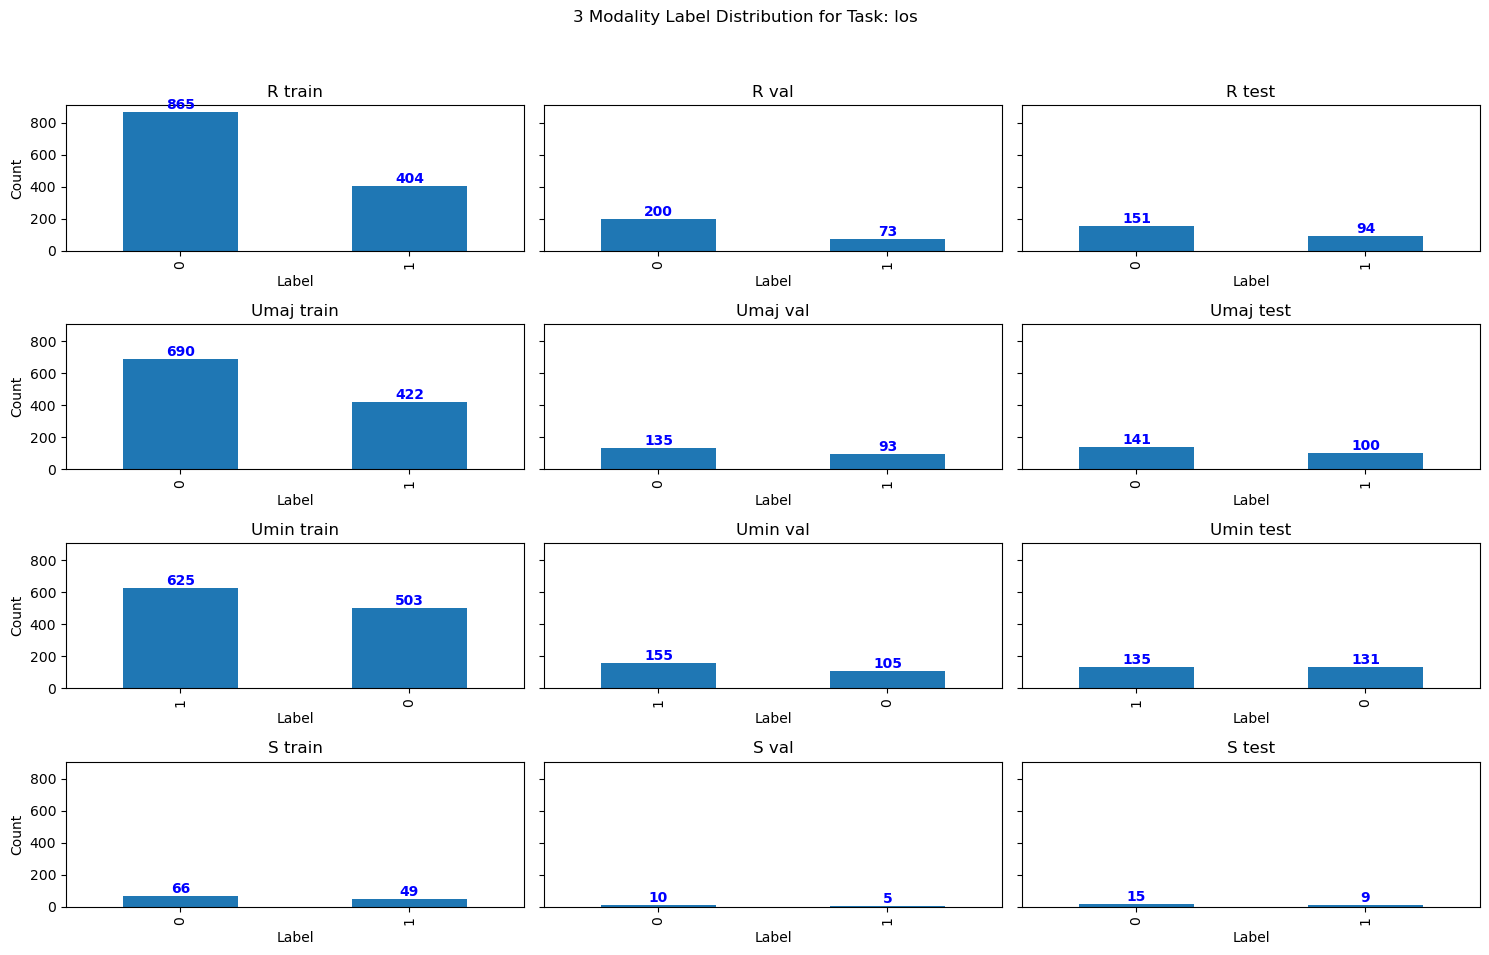

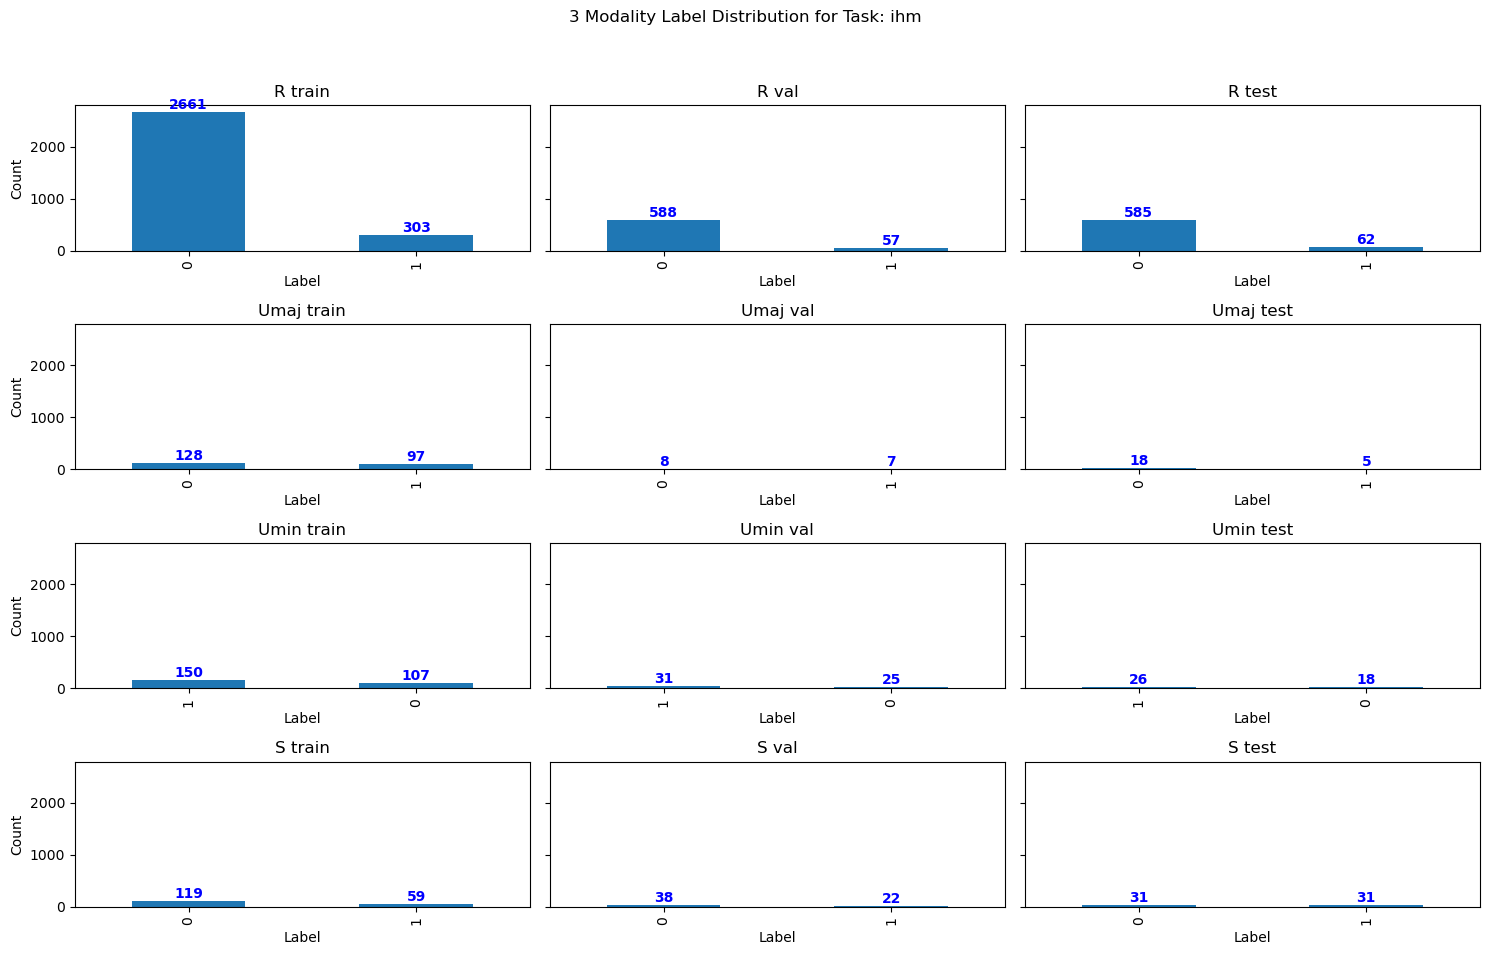

In [28]:
for task in tasks:
    fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(15, 10), sharey=True)
    fig.suptitle(f'3 Modality Label Distribution for Task: {task}')

    for i, PID in enumerate(PID_labels):
        for j, dataset_type in enumerate(dataset_types):
            ax = axes[i][j]
            data = label_distributions[task][PID][dataset_type]
            bars = data.plot(kind='bar', ax=ax, title=f'{PID} {dataset_type}')
            ax.set_xlabel('Label')
            ax.set_ylabel('Count')
            
            # Adding text labels inside the bars
            for bar in bars.patches:
                # Get the position of the bar (center for text) and the height (value for text)
                bar_x = bar.get_x() + bar.get_width() / 2
                bar_height = bar.get_height()
                ax.text(bar_x, bar_height, f'{int(bar_height)}', 
                        ha='center', va='bottom', fontweight='bold', color='blue')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()



In [33]:
tasks = ['los', 'ihm']
dataset_types = ['train', 'val', 'test']
PID_labels = ['R', 'U', 'S']

# Dictionary to hold label distributions
label_distributions = {}

for task in tasks:
    label_distributions[task] = {}
    for dataset_type in dataset_types:
        for PID in PID_labels:
            filepath = f'/data/wang/junh/datasets/multimodal/pid_2mod/TS_CXR/{dataset_type}_{task}_{PID}_stays.pkl'
            data = load_data(filepath)
            dist = get_label_distribution(data)
            label_distributions[task].setdefault(PID, {})[dataset_type] = dist

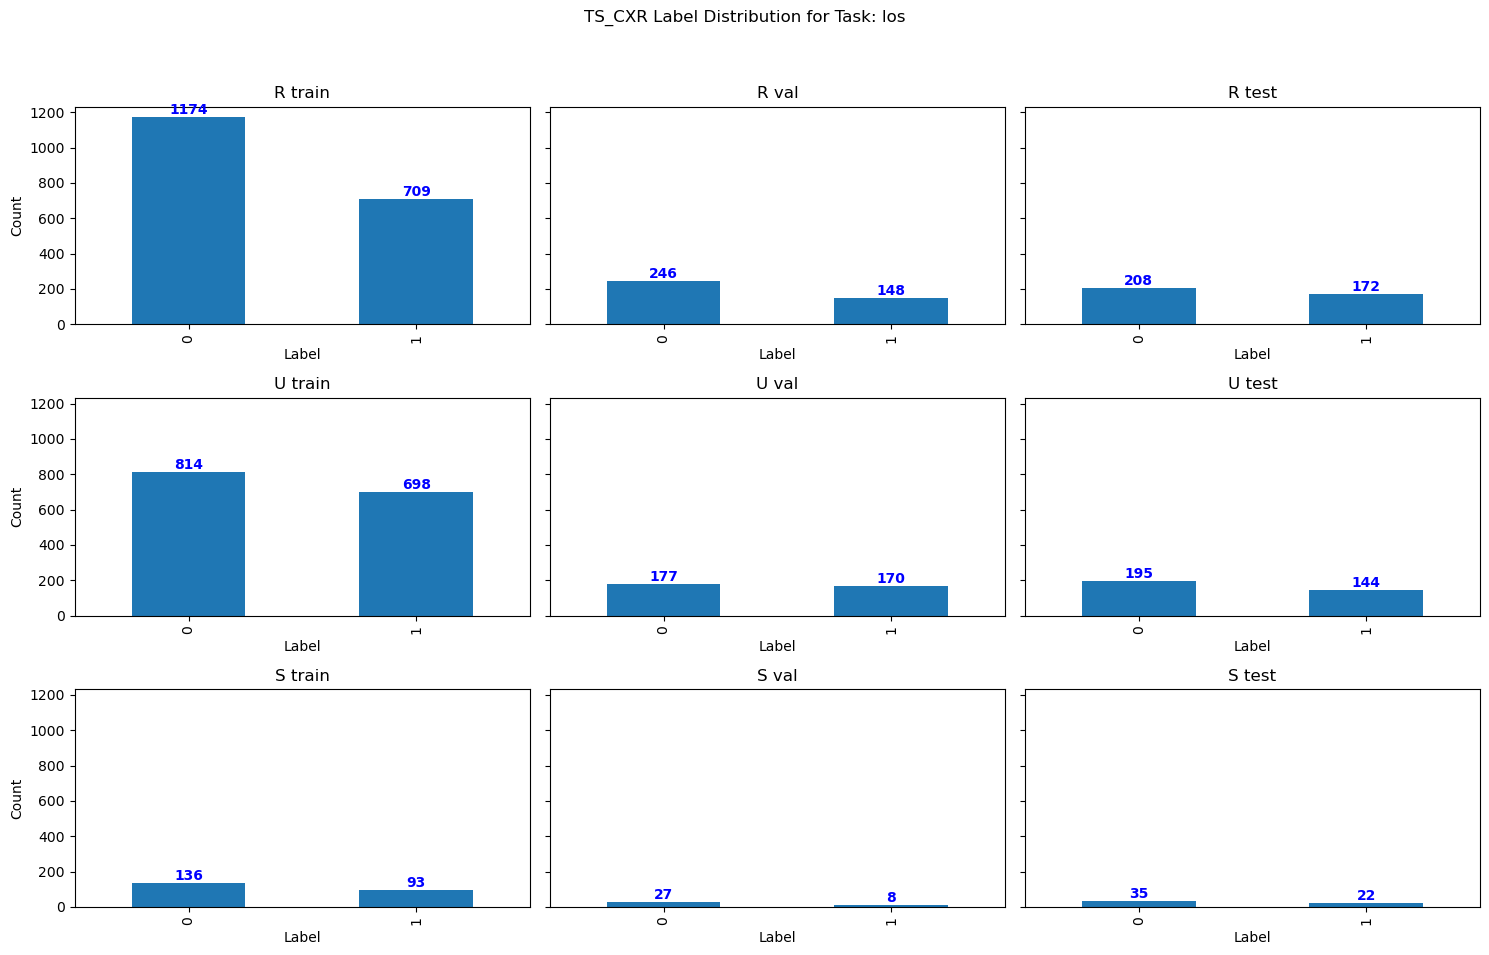

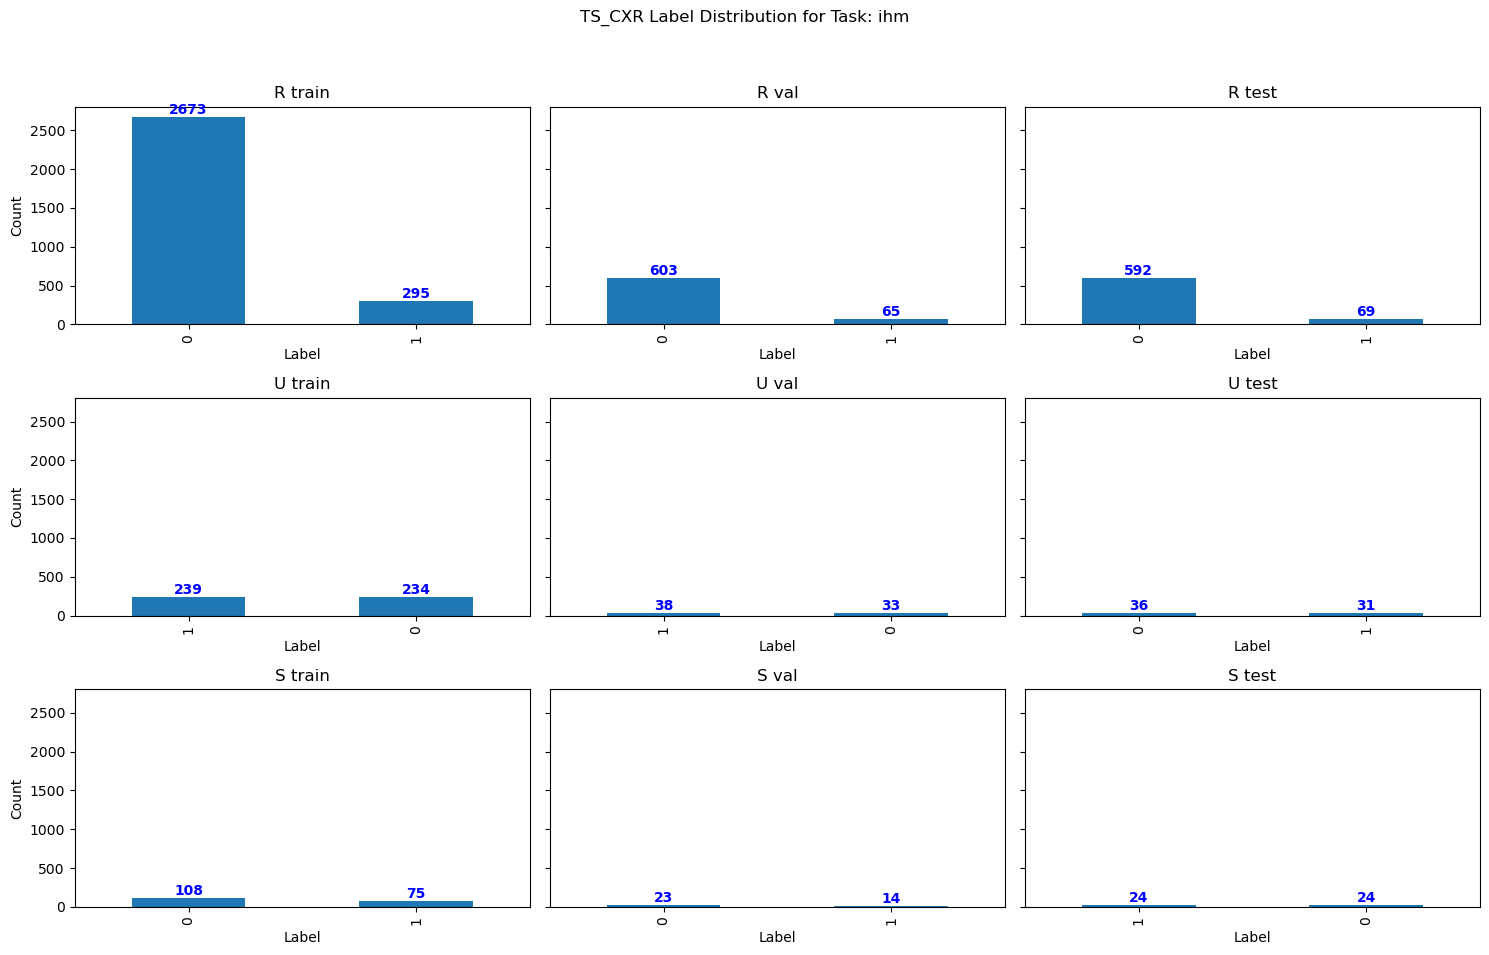

In [34]:
for task in tasks:
    fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 10), sharey=True)
    fig.suptitle(f'TS_CXR Label Distribution for Task: {task}')

    for i, PID in enumerate(PID_labels):
        for j, dataset_type in enumerate(dataset_types):
            ax = axes[i][j]
            data = label_distributions[task][PID][dataset_type]
            bars = data.plot(kind='bar', ax=ax, title=f'{PID} {dataset_type}')
            ax.set_xlabel('Label')
            ax.set_ylabel('Count')
            
            # Adding text labels inside the bars
            for bar in bars.patches:
                # Get the position of the bar (center for text) and the height (value for text)
                bar_x = bar.get_x() + bar.get_width() / 2
                bar_height = bar.get_height()
                ax.text(bar_x, bar_height, f'{int(bar_height)}', 
                        ha='center', va='bottom', fontweight='bold', color='blue')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

In [35]:
tasks = ['los', 'ihm']
dataset_types = ['train', 'val', 'test']
PID_labels = ['R', 'U', 'S']

# Dictionary to hold label distributions
label_distributions = {}

for task in tasks:
    label_distributions[task] = {}
    for dataset_type in dataset_types:
        for PID in PID_labels:
            filepath = f'/data/wang/junh/datasets/multimodal/pid_2mod/TS_Text/{dataset_type}_{task}_{PID}_stays.pkl'
            data = load_data(filepath)
            dist = get_label_distribution(data)
            label_distributions[task].setdefault(PID, {})[dataset_type] = dist

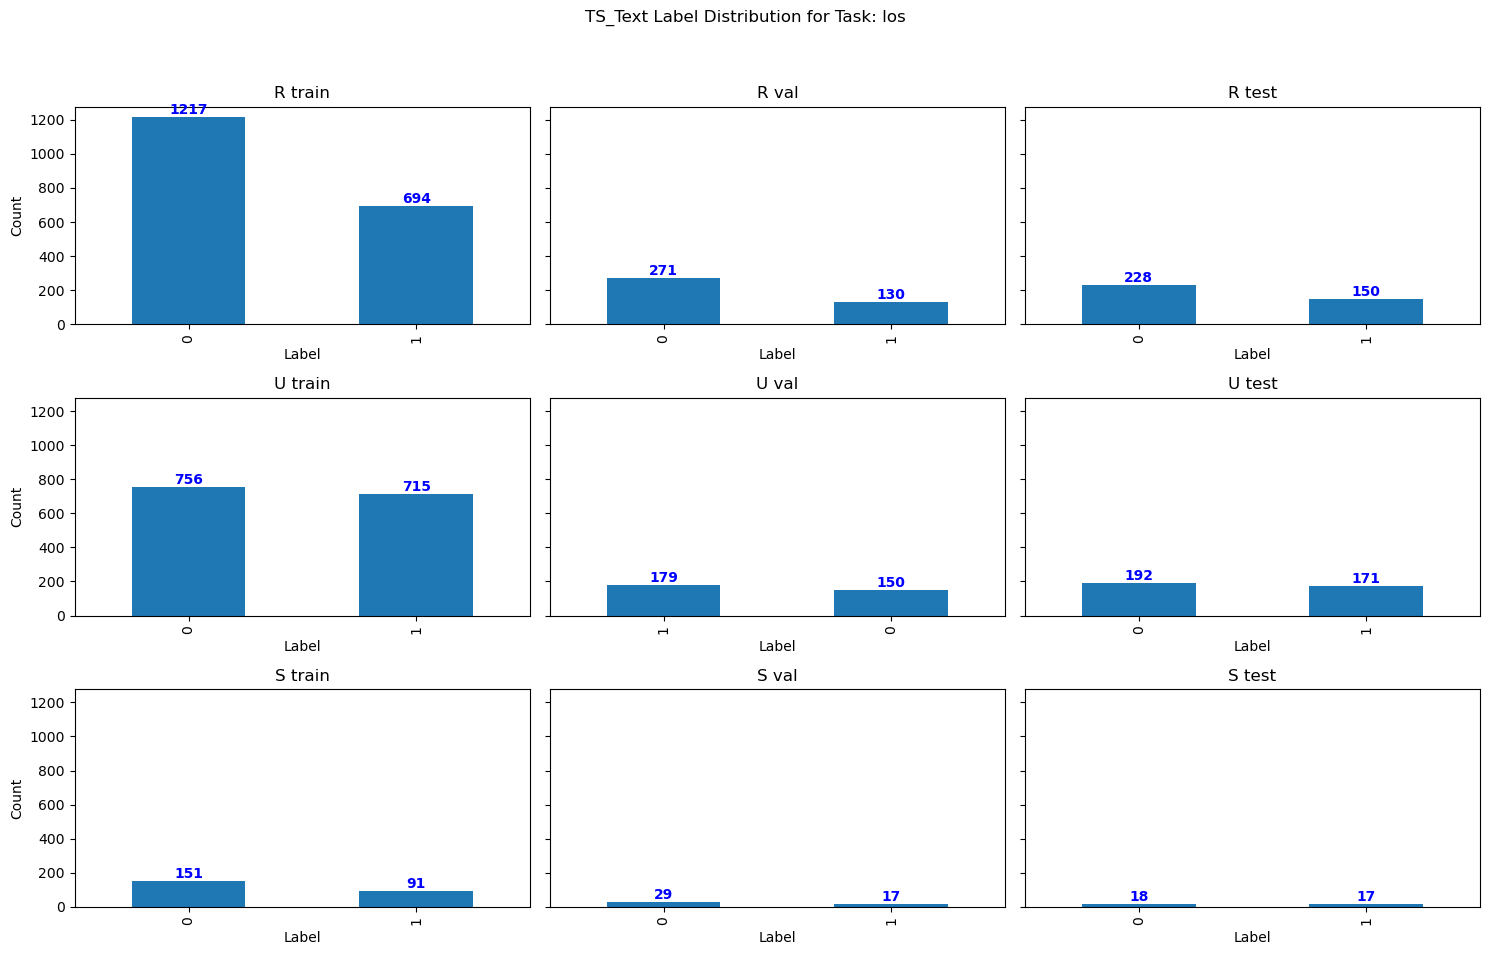

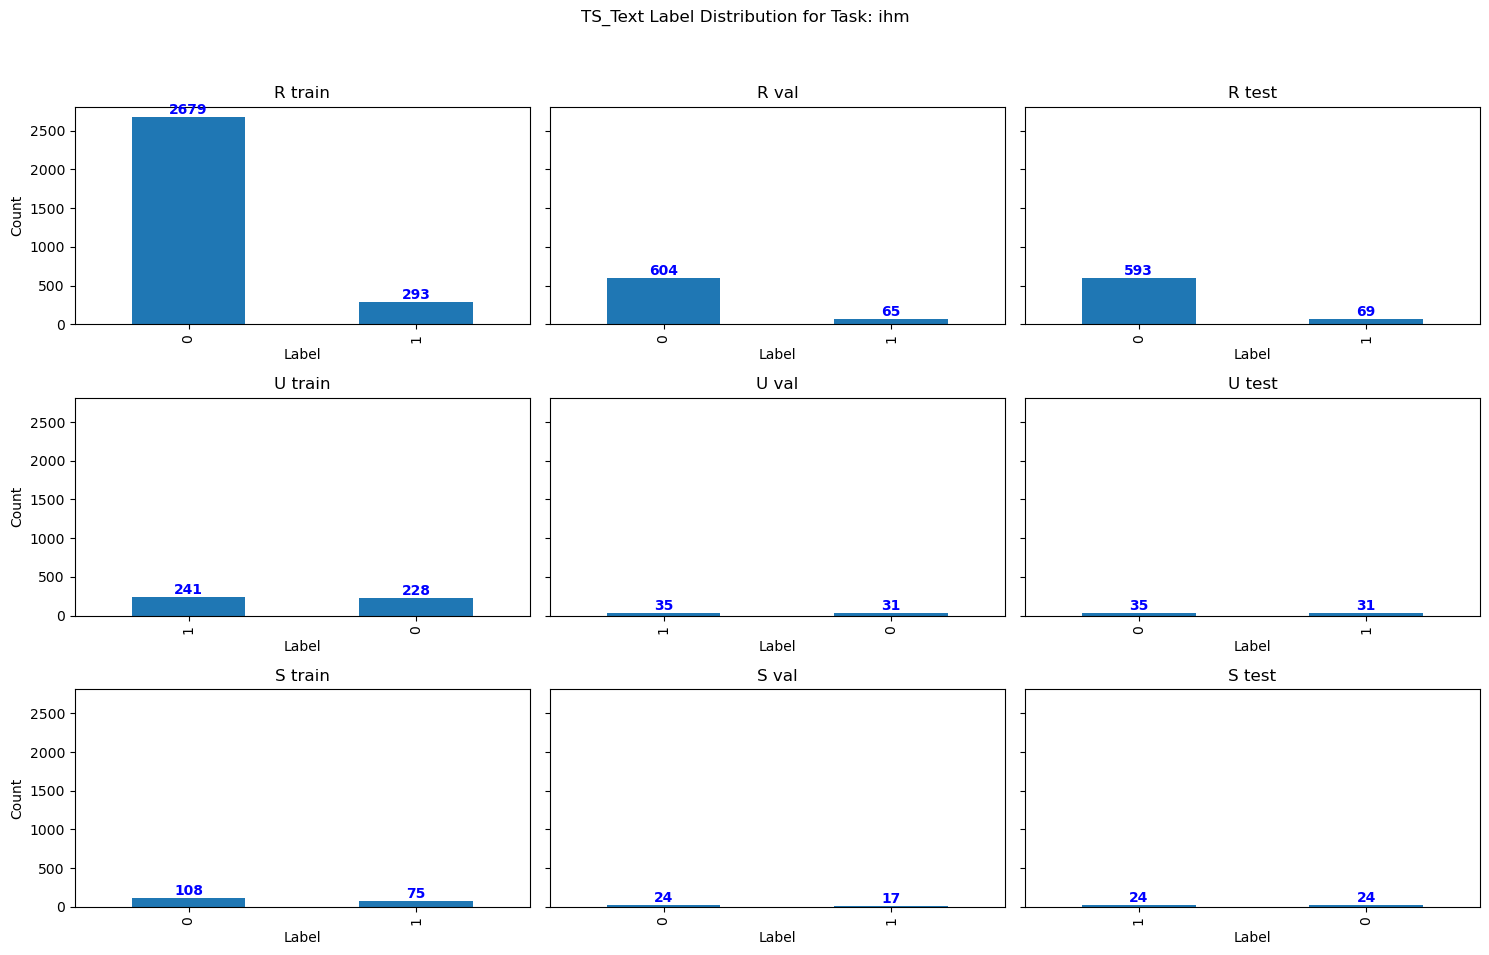

In [36]:
for task in tasks:
    fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 10), sharey=True)
    fig.suptitle(f'TS_Text Label Distribution for Task: {task}')

    for i, PID in enumerate(PID_labels):
        for j, dataset_type in enumerate(dataset_types):
            ax = axes[i][j]
            data = label_distributions[task][PID][dataset_type]
            bars = data.plot(kind='bar', ax=ax, title=f'{PID} {dataset_type}')
            ax.set_xlabel('Label')
            ax.set_ylabel('Count')
            
            # Adding text labels inside the bars
            for bar in bars.patches:
                # Get the position of the bar (center for text) and the height (value for text)
                bar_x = bar.get_x() + bar.get_width() / 2
                bar_height = bar.get_height()
                ax.text(bar_x, bar_height, f'{int(bar_height)}', 
                        ha='center', va='bottom', fontweight='bold', color='blue')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()